In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import anndata

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

Import two different UMI-based datasets using two different technologies: 10X Genomics and MARS-Seq

In [ ]:
pbmc3k = sc.datasets.pbmc3k() #10X
pbmc3k.uns['dataset'] = "10X_PBMC3k"
paul15 = sc.datasets.paul15() #Mars-seq
paul15.uns['dataset'] = "Paul15"

In [ ]:
datasets = [pbmc3k,paul15]

In [ ]:
#remove all genes with zero sums
for idx,adata in enumerate(datasets):
    undetected_genes = (adata.X.sum(0) == 0).sum()
    print(f"Removing {undetected_genes} undetected genes")
    datasets[idx] = datasets[idx][: , datasets[idx].X.sum(axis=0)>0]

Calculate mean, variance, and dropout rate

In [ ]:
for adata in datasets:
    if not isinstance(adata.X, np.ndarray):
        mean_ = adata.X.toarray().mean(0) #gene means
        var_ = np.var(adata.X.toarray(),axis=0) #gene vars
        frac_zero = 1 - (adata.X.toarray() > 0).sum(0) / adata.shape[0] #dropouts

    else:
        mean_ = adata.X.mean(0) #gene means
        var_ = np.var(adata.X,axis=0) #gene vars
        frac_zero = 1 - (adata.X > 0).sum(0) / adata.shape[0] #dropouts
    
    #copy all to anndata
    adata.var['mean_'] = mean_.copy()
    adata.var['var_'] = var_.copy()
    adata.var['frac_zero'] = frac_zero.copy()


Create a fitted model for both a poisson and negative binomial model to see which one best fits the data

In [ ]:
for adata in datasets:
    #calculate negative binomial dispersion
    phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, adata.var.mean_.values , adata.var.var_.values)
    #store in uns
    adata.uns['phi'] = phi_hat
    mm = np.logspace(np.log10(adata.var.mean_.values.min()), np.log10(adata.var.mean_.values.max()))
    plt.scatter(adata.var.mean_, adata.var.var_, c='k', label="observed RNA", rasterized=True)
    plt.loglog()
    plt.xlim(1e-4, 1e2)
    plt.ylim(1e-4, 1e5)

    plt.plot(mm, mm, label = 'Poisson', c='r') #poisson
    plt.plot(mm, mm + adata.uns['phi'] * mm ** 2, label = "Negative Binomial") #negative binomial

    plt.legend()
    plt.show()

In [ ]:
counts = datasets[0].X
if not isinstance(counts, np.ndarray):
        counts = counts.toarray()
tjs = np.sum(counts, axis=0, keepdims=True) #number of molecuels per gene
tis = np.sum(counts, axis=1, keepdims=True) #number of molecules per cell
total = sum(tis)

### Dropout feature selection

Here we can see that single-cell data is overdispersed, particularly at higher counts. This shows that the mean-variance relationship resembles a negative binomial relationship as opposed to a poisson. However, this is not to say that some genes can also follow a poisson model, especially at lower counts

The below function is used to calculate the depth adjusted mean and variance for each gene as well following the methodology outlined [here](https://academic.oup.com/bioinformatics/article/35/16/2865/5258099)

In [ ]:
def negbinom_fit(adata, chunk):

    def calculate_statistics(adata):
        
        counts = adata.X #extract counts
        if not isinstance(counts, np.ndarray):
            counts = counts.toarray()
        if (counts < 0).sum().sum() > 0:
            raise ValueError("Expression matrix contains negative values. Please provide raw UMI counts.")

        if (counts >= 1).sum().sum() != (counts > 0).sum().sum():
            raise ValueError("Error: Expression matrix is not integers. Please provide raw UMI counts.")
        
        if (counts.sum(axis=0) == 0).sum() > 1:
            raise ValueError("Error: Expression matrix contains genes with zero counts across all cells. Please remove these genes.")

        tjs = np.sum(counts, axis=0, keepdims=True) #number of molecuels per gene
        tis = np.sum(counts, axis=1, keepdims=True) #number of molecules per cell
        djs = np.array(counts.shape[0] - (counts > 0).sum(0)).flatten() #dropouts per gene
        dis = np.array(counts.shape[1] - (counts > 0).sum(1)).flatten() #dropouts per cell
        nc = counts.shape[0] #total cells
        ng = counts.shape[1] #total genes
        total = sum(tis) #total molecules

        return {
            'tjs': tjs,
            'tis': tis,
            'dis': dis,
            'djs': djs,
            'total': total,
            'nc': nc,
            'ng': ng
        }

    vals = calculate_statistics(adata)
    counts = adata.X
    if not isinstance(counts, np.ndarray):
        counts = counts.toarray()
    batch_size = chunk  # Adjust as needed; this is for data management
    ng = vals['ng'] #extract total number of genes
    nc = vals['nc']
    gene_vars = np.empty(ng) #create an empy array containing the total number of genes
    mus = np.empty((nc, counts.shape[1])) # create an empty array for mu_is
    
    for i in range(0, ng, batch_size):
            batch_end = min(i + batch_size, ng)

            # Calculate #null model
            mu_batch = (vals['tis'] @ vals['tjs'][:, i:batch_end]) / vals['total']

            mus[:, i:batch_end] = mu_batch
            
            # Compute my_rowvars for the current batch using vectorized operations
            gene_vars[i:batch_end] = np.var(counts[:, i:batch_end] - mu_batch, axis=0, keepdims=True)
    
    #dispersion sizes paramater estimation
    theta = (vals['tjs']) * (np.sum(vals['tis'] ** 2) / vals['total'] ** 2) / ((vals['nc'] - 1) * gene_vars - vals['tjs'])

    #handling for poisson behavior
    min_size = 1e-10
    max_size = 10 * np.max(theta)
    theta[theta < 0] = max_size
    theta[theta < min_size] = min_size
    
    return {
        'gene_names' : adata.var_names,
        'var_obs': gene_vars.reshape(1,-1),
        'theta': theta,
        'vals': vals,
        "mus": mus
    }


Create fitted statistics to the data

In [ ]:
fit = {}
for idx,adata in enumerate(datasets):

    fit[idx] = negbinom_fit(adata, chunk=1000)

Now we want to find genes with significant dropouts when compared to a NULL negative binomial model. Genes that follow the expected model will not be biologically relevant due to their dropout rate following the negative binomial distribution. However, genes with higher than expected dropouts can be investigated due to some attributal biological variation between cell types/states. 

In [ ]:
from scipy.stats import norm
from scipy import optimize
from statsmodels.stats.multitest import multipletests
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb

def negbinom_dropout_features(fit,adata,ntop=None,method="fdr_bh", qval_thresh=0.01, suppress_plot=True, clip=None):
    
    vals = fit['vals'] #extract vals dictionary
    xes = (vals['tjs'] / vals['nc']).reshape(-1) #calculate the mean expression
    phi, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, xes, fit['var_obs'].reshape(-1)) #calculate the dispersion parameter based on data
    NB_drop_prob = lambda mu, phi: ((1. / phi) / (mu + (1. / phi))) ** (1. / phi) #probability function of finding zero given mean and dispersion
    droprate_exp = np.zeros(vals['ng'])
    droprate_exp_err = np.zeros(vals['ng'])

    for i in range(vals['ng']):
        mu_i = xes[i] #extract mean for each gene in the array
        droprate_exp[i] = NB_drop_prob(mu_i, phi) #gene-wise expected droprate given expression

    droprate_exp_err = np.sqrt(droprate_exp * (1 - droprate_exp) / vals['nc']) #standard error for expectation

    droprate_obs = vals['djs'] / vals['nc'] #droprate observed
    droprate_obs_err = np.sqrt(droprate_obs * (1 - droprate_obs) / vals['nc']) #standard error for observed

    combined_err = np.sqrt(droprate_exp_err**2 + droprate_obs_err**2) #combined error
    diff = droprate_obs - droprate_exp #find differences
    Zed = diff / combined_err #calculate z-score

    #pearson residuals
    counts = adata.X
    if not isinstance(counts, np.ndarray):
        counts = counts.toarray()
    #pearson residuals
    theta=100

    #get residuals
    mu = fit['mus']
    z = (counts - mu) / np.sqrt(mu + mu**2/theta)

    # prepare clipping
    if clip is None:
        n = mu.shape[0]
        clip = np.sqrt(n)
    if clip < 0:
        raise ValueError("Pearson residuals require `clip>=0` or `clip=None`.")
        
    # clip
    z = np.clip(z, a_min=-clip, a_max=clip)

    #variance
    var = np.var(z, axis=0).flatten()
    p_value = (1 - norm.cdf(Zed)) #create normal distribution to extract p-values
    
    p_value = pd.DataFrame({'p_val':p_value,
                            'inv_diff':droprate_obs - droprate_exp,
                            'Zed':Zed,
                            'droprate_expected':droprate_exp,
                            'droprate_observed':droprate_obs,
                            'mean_expression':xes,
                            'residual_variance':var}, index=pd.array(fit['gene_names']))
    p_value = p_value.sort_values(by=['p_val', 'Zed'], ascending=[True,False]) #sort for benjamini-hochberg correction

    # Adjust p-values for multiple testing
    reject, q_val, _, _ = multipletests(np.array(p_value['p_val']), method="fdr_bh")
    p_value['q_val'] = q_val #add q-values to dataframe

    if ntop is not None:
        top_genes = np.argsort(list(p_value.values()))[:ntop]
    else:
        top_genes = [gene for i, gene in enumerate(p_value.index) if p_value.loc[gene]['q_val'] < qval_thresh]

    p_value['highly_variable'] =  p_value.index.isin(top_genes)

    if not suppress_plot:
        mm = np.logspace(min(np.log10(xes)), max(np.log10(xes)), num=vals['ng'])
        phi, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, xes, fit['var_obs'].reshape(-1))
        NB_drop_prob = lambda mu, phi: ((1. / phi) / (mu + (1. / phi))) ** (1. / phi)
        plt.scatter(p_value.mean_expression, p_value.droprate_observed, c=p_value.q_val, cmap='viridis_r', alpha=0.8)
        plt.plot(mm, NB_drop_prob(mm, phi), c='r', lw=2)
        plt.colorbar()
        plt.gcf().axes
        plt.gcf().axes[1].set(title=f'FDR')
        plt.xscale('log')

    return {
        "features_df":p_value,
        "analytic_pearson":z
    }

In [ ]:
features = {}
features[0] = negbinom_dropout_features(fit=fit[0],adata=datasets[0],suppress_plot=False, qval_thresh=0.01)

In [ ]:
features[1] = negbinom_dropout_features(fit=fit[1],adata=datasets[1],suppress_plot=False, qval_thresh=0.01)

Selecting for significant dropouts

In [ ]:
import seaborn as sns
def select_dropouts(adata, nb_df, suppress_plot=False, ident='highly_variable'):
    adata.var[ident] = adata.var.index.isin(nb_df.loc[nb_df[ident]].index)
    
    if not suppress_plot:
        sns.scatterplot(data=adata.var, x="mean_", y="frac_zero", hue=ident)
    plt.xlabel("Mean Expression")
    plt.ylabel("Dropout Rate")
    plt.xscale('log')
    plt.legend(title="Biological Dropouts", loc="upper right")
    plt.show()  # Show each scatterplot separately

In [ ]:
select_dropouts(datasets[0], nb_df=features[0]['features_df'], suppress_plot=False)

In [ ]:
select_dropouts(datasets[1], nb_df=features[1]['features_df'], suppress_plot=False)

### Pearson residual evaluation

In [ ]:
for idx,adata in enumerate(datasets):
    dataset = adata.uns['dataset']
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    p1 = sns.histplot(adata.X.sum(1), bins=100, kde=False, ax=axes[0])
    axes[0].set_title(f'Total counts {dataset}')
    p2 = sns.histplot(features[idx]["analytic_pearson"].sum(1), bins=100, kde=False, ax=axes[1])
    axes[1].set_title(f'Analytic Pearson residuals {dataset}')
    plt.show()

In [ ]:
for idx in features.keys():
    dataset = datasets[idx].uns['dataset']
    df = features[idx]['features_df']
    highly_variable = df[df['highly_variable'] == True]
    not_highly_variable = df[df['highly_variable'] == False]
    plt.scatter(x=not_highly_variable.mean_expression,y=not_highly_variable.residual_variance, c='blue',s=2)
    plt.scatter(x=highly_variable.mean_expression,y=highly_variable.residual_variance, c='red',s=2, label='selection by dropouts')
    plt.loglog()
    plt.axhline(y=1, c='k', linestyle='--',alpha=0.6)
    plt.legend()
    plt.title(r'Pearson residuals ($\theta=100$) ' + dataset)
    plt.show()

In [ ]:
for idx,adata in enumerate(datasets):
    adata.layers['raw'] = adata.X.copy()
    mat = np.array(features[idx]['analytic_pearson'], dtype=np.float32).copy()
    adata.layers['pr'] = mat

In [ ]:
for adata in datasets:
    sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)
    sc.tl.umap(adata)


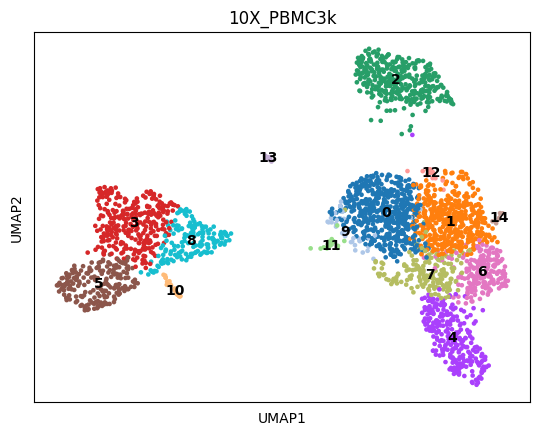

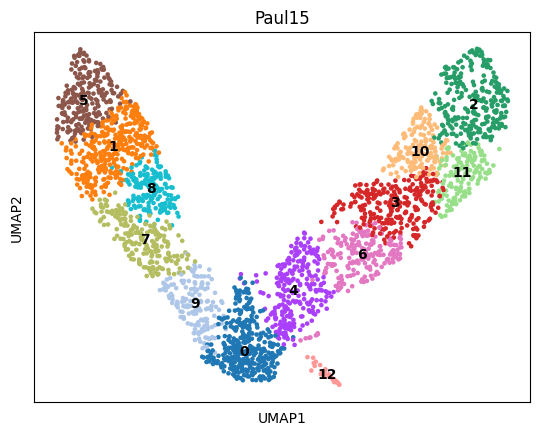

In [22]:
for adata in datasets:
    ax = sc.pl.umap(adata,color='leiden', legend_loc="on data", show=False)
    ax.set_title(adata.uns['dataset'])
    plt.show()

We can select for biologically relevant genes based on the amount of dropouts when compared to a NULL negative binomial distribution of the data given the predicted dropout rate given mean expression

As we can see, there is some descrepency between using genes with significant dropouts and analytic pearson residual variance. More benchmarking would be necessary and tailored to each dataset. For instance, in the Paul15 dataset which represents many transitioning cells, the dropout rate may exist along a continuoum and not be binarized into presence and absence. However, for the PBMC dataset, cells are much more heterogenous in nature with genes being "on" and "off" more obvious between cell types signifying more dropouts and heterogeneity.

Looking at this data highlights the certain assumptions each model makes and how that contributes to its relative performance on calculating genes to use for dimensionality reduction. For instance, the overdispersion parameter, theta, has a significant impact on building the NULL model to compare against when calculating pearson residuals. As theta->infinity, the pearson residuals are compared to a poisson model, but changing this paramater changes the interpretation of biologically relevent genes as pointed out in Lause et al. (2021).

As a result, no model is perfect and it is important to take all these factors into consideration when interpreting single-cell data. As each iteration in the downstream processing distorts the data in slightly different ways, we must continue to be careful in how we analyze the data.